## Decision Tree Examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

## Example 1

#### Entropy
Shannon's entropy is defined for a system with N possible states as follows:

$$\Large S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$

where $p_i$ is the probability of finding the system in the $i$-th state. This is a very important concept used in physics, information theory, and other areas. Entropy can be described as the degree of chaos in the system. The higher the entropy, the less ordered the system and vice versa. This will help us formalize "effective data splitting".


In [2]:
# first class
np.random.seed(17)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Here our goal is to build some "good" boundary separating the two classes (the red dots from the yellow). Machine learning for this case boils down to choosing a good separating border. A straight line will be too simple while some complex curve snaking by each red dot will be too complex and will lead us to making mistakes on new samples. Intuitively, some smooth boundary, or at least a straight line or a hyperplane, would work well on new data.

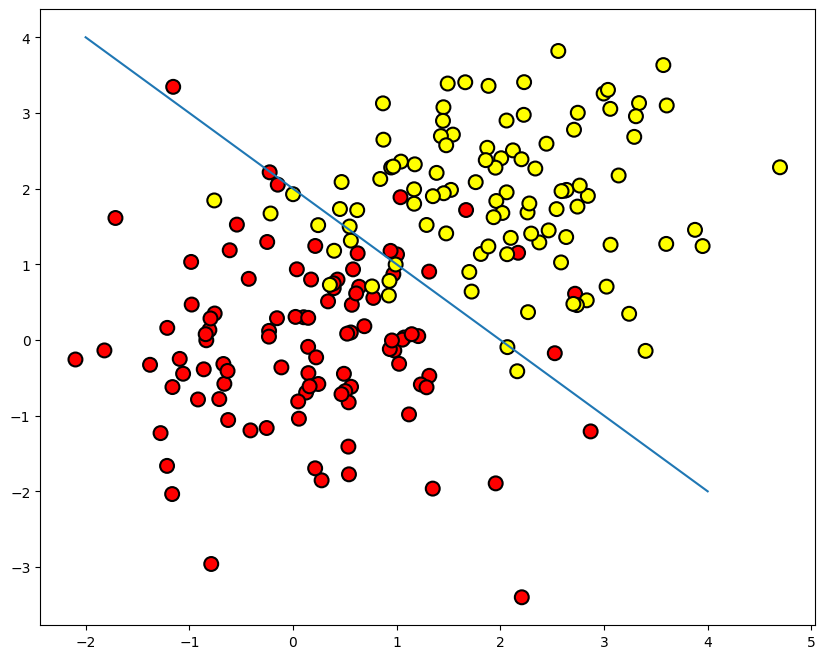

In [3]:
plt.figure(figsize=(10,8))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

#### Create a Decision Tree Classifier and fit the training data set

In [4]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, 
                                  random_state=17)
# training the tree
clf_tree.fit(train_data, train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

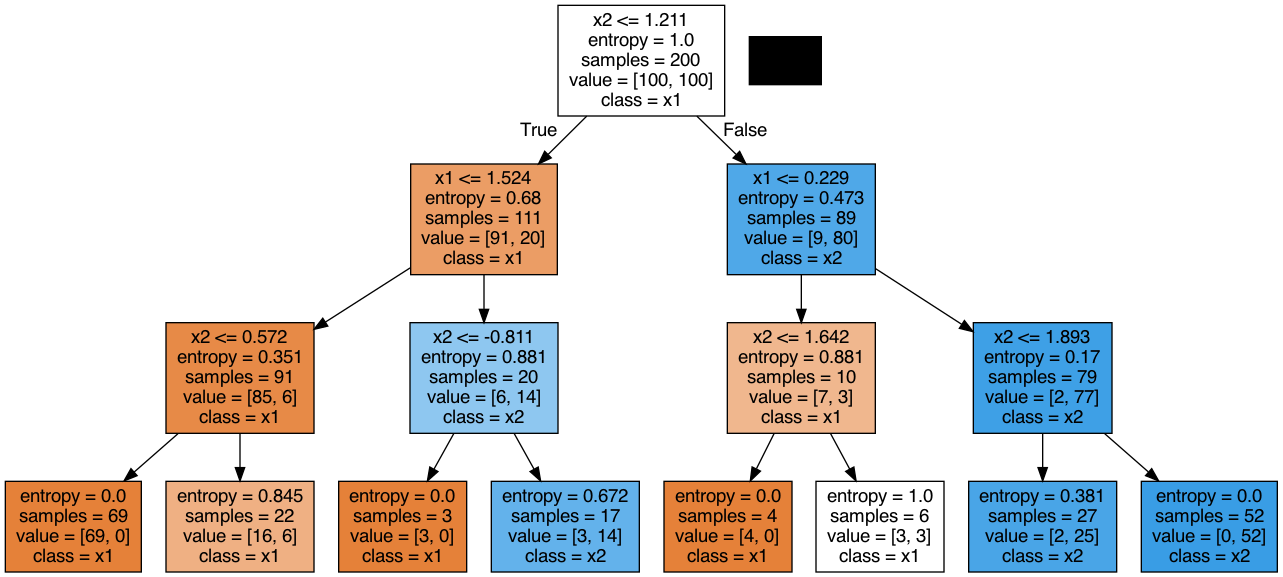

In [5]:
import pydotplus 
from  sklearn import tree
from IPython.display import Image
dot_data = tree.export_graphviz(clf_tree, feature_names=['x1', 'x2']
                , class_names=['x1', 'x2'],filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

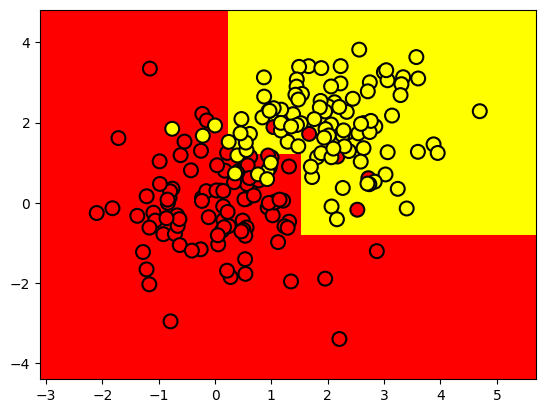

In [6]:
# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

#### How can we "read" such a tree?

In the beginning, there were 200 samples (instances), 100 of each class. The entropy of the initial state was maximal, 𝑆=1
. Then, the first partition of the samples into 2 groups was made by comparing the value of 𝑥2 with 1.211 (find this part of the border in the picture above). With that, the entropy of both left and right groups decreased. The process continues up to depth 3. In this visualization, the more samples of the first class, the darker the orange color of the vertex; the more samples of the second class, the darker the blue. At the beginning, the number of samples from two classes is equal, so the root node of the tree is white.

## Example 2: How a Decision Tree Works with Numerical Features

Suppose we have a numeric feature "Age" that has a lot of unique values. A decision tree will look for the best (according to some criterion of information gain) split by checking binary attributes such as "Age <17", "Age < 22.87", and so on. But what if the age range is large? Or what if another quantitative variable, "salary", can also be "cut" in many ways? There will be too many binary attributes to select from at each step during tree construction. To resolve this problem, heuristics are usually used to limit the number of thresholds to which we compare the quantitative variable.

In [7]:
import pandas as pd
data = pd.DataFrame({'Age':  [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33], 
                      'Salary': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88], 
             'Loan Default': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data

,Age,Salary,Loan Default
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


In [8]:
treeAgeSalary = DecisionTreeClassifier(random_state=17)
treeAgeSalary .fit(data[['Age', 'Salary']].values, data['Loan Default'].values);

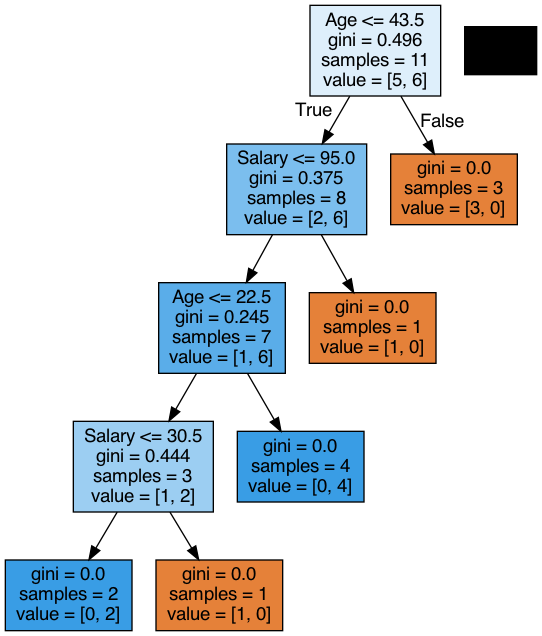

In [9]:
dot_data = tree.export_graphviz(treeAgeSalary, feature_names=['Age','Salary']
                ,filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

Tree partitioned by both salary and age. In addition, the thresholds for feature comparisons are 43.5 and 22.5 years of age and 95k and 30.5k per year. We see that 95 is the average between 88 and 102; the individual with a salary of 88k proved to be "bad" while the one with 102k was "good". The same goes for 30.5k. That is, only a few values for comparisons by age and salary were searched. Why did the tree choose these features? Because they gave better partitioning (according to Gini uncertainty)! 

> the simplest heuristics for handling numeric features in a decision tree is to sort its values in ascending order and check only those thresholds where the value of the target variable changes.

> when there are a lot of numeric features in a dataset, each with a lot of unique values, only the top-N of the thresholds described above are selected, i.e. only use the top-N that give maximum gain. The process is to construct a tree of depth 1, compute the entropy (or Gini uncertainty), and select the best thresholds for comparison.